# Binary Task CNN Notebook

### Contains Code for Binary task CNN Model creation, training and testing<br/> CNN will be an implementation of AlexNet equivalent structure 5 convolutional layers and 3 fully connected layers

In [1]:
# Import required libraries
import numpy as np
from numpy import expand_dims
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

#tqdm is for progress bar functionality in code, must be installed for code to function (TO DO: include exception if tqdm not imported )
from tqdm import tqdm

import pickle as pkl
import cv2

#Libraries for CNN model
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import model_from_json

#Importing functions notebook containing functions created to streamline code
from ipynb.fs.full.functions import load_dataset_CNN

Using TensorFlow backend.


# 1. Loading Labels and Resized Image Dataset
### 1.1 Loading Dataset via load_dataset_CNN function in "function.ipynb"

In [2]:
#Calls load_dataset_CNN function from function.ipynb to obtain the MRI images dataset and the binary label pickle file and loads it respectively 
#into our X and Y value. Function also conducts rescaling of image pixel data from 0 to 255 to 0 to 1 range.
X, Y = load_dataset_CNN('./dataset/CNN_Images_2D_DF.pkl', './dataset/Y_Binary_label.pkl')

Datasets successfully loaded with shapes:
X Shape:
(3000, 50, 50, 1)
Y Shape:
(3000,)


### 1.2 Splitting dataset

In [3]:
# Split the data into training and testing(70% training and 30% testing data)
xTrain,xTest,yTrain,yTest=train_test_split(X, Y, train_size = 0.7)

# 2. CNN Model Building

### 2.1 Defining model structure

In [4]:
#Initialising the Model
Binary_CNN = Sequential(name = 'Binary_CNN')

#We use the same number of filters in all convolutional layers of the AlexNet Model
#Number of filters in the fully connected layers will be reduced to 2500 2500 and 500
#This is to reduce size of CNN so it can be fit into Github without LFS
# Final output layer will have 1 node as it is binary classification

#1st Convolutional Layer
#Input arguements
#Filters: Number of output filters in convolution
Binary_CNN.add(Conv2D(filters = 96, input_shape = (X.shape[1], X.shape[2], 1), kernel_size = (11, 11), strides = (4, 4), padding = 'same', name="conv0"))
Binary_CNN.add(BatchNormalization(name = 'bn0'))
Binary_CNN.add(Activation('relu'))
Binary_CNN.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))


#2nd Convolutional Layer
Binary_CNN.add(Conv2D(filters = 256, kernel_size = (5, 5), strides = (1, 1), padding = 'same', name="conv1"))
Binary_CNN.add(BatchNormalization(name = 'bn1'))
Binary_CNN.add(Activation('relu'))
Binary_CNN.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))


#3rd Convolutional Layer
Binary_CNN.add(Conv2D(filters = 384, kernel_size = (3, 3), strides = (1, 1), padding = 'same', name="conv2"))
Binary_CNN.add(BatchNormalization(name = 'bn2'))
Binary_CNN.add(Activation('relu'))


#4th Convolutional Layer
Binary_CNN.add(Conv2D(filters = 384, kernel_size = (3, 3), strides = (1, 1), padding = 'same', name="conv3"))
Binary_CNN.add(BatchNormalization(name = 'bn3'))
Binary_CNN.add(Activation('relu'))


#5th Convolutional Layer
Binary_CNN.add(Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', name="conv4"))
Binary_CNN.add(BatchNormalization(name = 'bn4'))
Binary_CNN.add(Activation('relu'))
Binary_CNN.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))


#Passing through the Fully connected layers
#We set the number of neurons per layer as 2500 for now
#Less than orignal 4096
Binary_CNN.add(Flatten())

#1st Fully Connected Layer
Binary_CNN.add(Dense(2500, name = 'fc0'))
Binary_CNN.add(BatchNormalization(name = 'bnfc0'))
Binary_CNN.add(Activation('relu'))
Binary_CNN.add(Dropout(0.4))

#2nd Fully Connected Layer
Binary_CNN.add(Dense(2500, name = 'fc1'))
Binary_CNN.add(BatchNormalization(name = 'bnfc1'))
Binary_CNN.add(Activation('relu'))
Binary_CNN.add(Dropout(0.4))

#3rd Fully Connected Layer
Binary_CNN.add(Dense(500, name = 'fc2'))
Binary_CNN.add(BatchNormalization(name = 'bnfc2'))
Binary_CNN.add(Activation('relu'))
Binary_CNN.add(Dropout(0.4))


#Output Layer
Binary_CNN.add(Dense(1, name = 'fcOut'))
Binary_CNN.add(BatchNormalization())
Binary_CNN.add(Activation('sigmoid'))



Binary_CNN.summary()

Model: "Binary_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 13, 13, 96)        11712     
_________________________________________________________________
bn0 (BatchNormalization)     (None, 13, 13, 96)        384       
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 96)          0         
_________________________________________________________________
conv1 (Conv2D)               (None, 7, 7, 256)         614656    
_________________________________________________________________
bn1 (BatchNormalization)     (None, 7, 7, 256)         1024      
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 256)         0

### 2.2 Compiling Binary CNN Model

In [5]:
#Compiling the model
Binary_CNN.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy', metrics.BinaryAccuracy(), metrics.AUC()])

### 2.3 Model Training
#### 2.3.1 Defining model training callbacks and parameters

In [6]:
#Learning Rate callback
from keras.callbacks import ReduceLROnPlateau
lrr= ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.01, patience = 3, min_lr = 1e-5) 

#Defining model training parameters
batch_size = 50
epochs = 20
learn_rate = 0.001

#### 2.3.2 Training Model with validation set derived from training dataset

In [7]:
#Training the Model
#Explanation of the fit arguements
#Validation_split splits the training data and uses that split set aside for model validation

Binary_CNN.fit(xTrain, yTrain, batch_size= batch_size, epochs= epochs, validation_split= 0.3,  verbose = 1, callbacks = [lrr])
#History.history attribute is a record of training loss values and metrics values at successive epochs
#as well as validation loss values and validation metrics values (if applicable).

Train on 1470 samples, validate on 630 samples
Epoch 1/20
1470/1470 [==============================] - 22s 15ms/step - loss: 0.6600 - accuracy: 0.7633 - binary_accuracy: 0.7633 - auc_1: 0.7660 - val_loss: 1.0592 - val_accuracy: 0.1540 - val_binary_accuracy: 0.1540 - val_auc_1: 0.7369
Epoch 2/20
1470/1470 [==============================] - 3s 2ms/step - loss: 0.5672 - accuracy: 0.8347 - binary_accuracy: 0.8347 - auc_1: 0.9007 - val_loss: 0.4775 - val_accuracy: 0.8460 - val_binary_accuracy: 0.8460 - val_auc_1: 0.5881
Epoch 3/20
1470/1470 [==============================] - 3s 2ms/step - loss: 0.5121 - accuracy: 0.8932 - binary_accuracy: 0.8932 - auc_1: 0.9315 - val_loss: 0.6264 - val_accuracy: 0.8730 - val_binary_accuracy: 0.8730 - val_auc_1: 0.7491
Epoch 4/20
1470/1470 [==============================] - 2s 2ms/step - loss: 0.4640 - accuracy: 0.9381 - binary_accuracy: 0.9381 - auc_1: 0.9692 - val_loss: 1.3975 - val_accuracy: 0.1540 - val_binary_accuracy: 0.1540 - val_auc_1: 0.7743
Epoch 5

### 2.4 Assessing Model Training Performance

In [9]:
#Testing addressing of trained model history metrics
#Allows us to access the model training history stats such as accuracy in trianing and validation
print(Binary_CNN.history.history.keys())

#Obtains training accuracy and loss of the most recent epoch to be finished
acc = Binary_CNN.history.history['accuracy'][-1]
loss = Binary_CNN.history.history['loss'][-1]

print("Training accuracy: ", acc)
print("Training loss: ", loss)


Training accuracy:  0.9897959
Training loss:  0.3884370148587389


#### 2.4.1 Visualising Model parameters during training

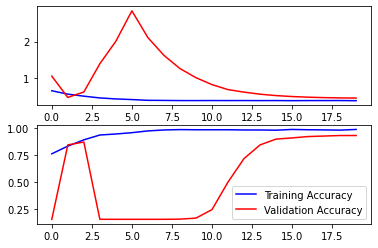

In [10]:
#Plotting the Training and validation loss

#Creating 2 subsplots under 1 figure
f, acc_plot = plt.subplots(2,1)

#First subplot graphs training loss and validation loss
acc_plot[0].plot(Binary_CNN.history.history['loss'], color = 'b', label = 'Training Loss')
acc_plot[0].plot(Binary_CNN.history.history['val_loss'], color = 'r', label = 'Validation Loss')

#Second subplot graphs training accuracy and validation accuracy
acc_plot[1].plot(Binary_CNN.history.history['accuracy'], color = 'b', label = 'Training Accuracy')
acc_plot[1].plot(Binary_CNN.history.history['val_accuracy'], color = 'r', label = 'Validation Accuracy')

plt.legend()

# 3. Making Predictions with Trained Model

### 3.1 Obtaining Classification report and confusion matrix

In [11]:
#Making Predictions with the model
#We make 2 sets of predictions using the trained model. One which predicts the absolute class of the test image 
#and another subsequently which provides probability of the labels (0 or 1). The latter is used for ROC curve plotting
Binary_CNN_pred = Binary_CNN.predict_classes(xTest, verbose = 1)

#Printing the classification report and metrics
print("The Results for Binary CNN are:")
print(classification_report(yTest, Binary_CNN_pred))

#Printing the confusion matrix for Binary CNN
print("The confusion matrix is:")
print(confusion_matrix(yTest, Binary_CNN_pred))

900/900 [==============================] - 1s 1ms/step
The Results for Binary CNN are:
              precision    recall  f1-score   support

         0.0       0.80      0.81      0.80       146
         1.0       0.96      0.96      0.96       754

    accuracy                           0.94       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.94      0.94      0.94       900

The confusion matrix is:
[[118  28]
 [ 30 724]]


### 3.2 Obtaining ROC curve metrics of Binary CNN model

In [12]:
#And the 2nd one being the probability of label for ROC curve assessment
Binary_CNN_pred_probability = Binary_CNN.predict_proba(xTest, verbose = 1)
FPR_Binary_CNN, TPR_Binary_CNN, Binary_CNN_thres = roc_curve(yTest, Binary_CNN_pred_probability)
print('roc_auc_score for Binary CNN: ', roc_auc_score(yTest, Binary_CNN_pred_probability))

900/900 [==============================] - 0s 427us/step
roc_auc_score for Binary CNN:  0.947667235928927


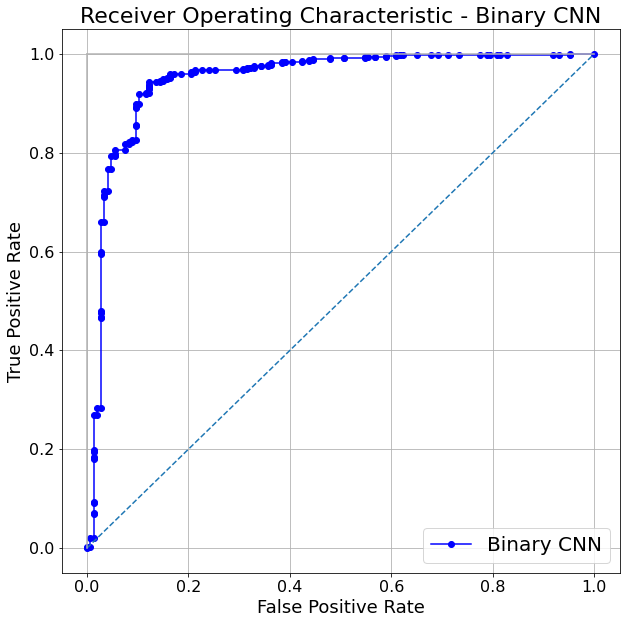

In [13]:
#We can visualise the ROC curve for Binary CNN

plt.subplots(1, figsize=(10,10))
plt.grid()

#This plot is the CNN model
plt.plot(FPR_Binary_CNN, TPR_Binary_CNN, linestyle='-', color='b', marker='o', label ="Binary CNN")

#Optimal Model line
plt.plot([0, 1], ls="--")

#Diagonal Dotted Line
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")

#Labels for title and axis
plt.title('Receiver Operating Characteristic - Binary CNN', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=20)

#Saves plot to be used in the report
plt.savefig('./Plots/ROC_Binary_CNN.jpg', bbox_inches='tight')

# 4. Saving Model

In [14]:
#Serialize Binary CNN model to json
#This saves the model architecture to save space
Binary_CNN_json = Binary_CNN.to_json()
with open(".\Models\Binary-Classification\CNN\Binary_CNN.json", "w") as json_file:
    json_file.write(Binary_CNN_json)

#Saving the Binary_CNN Model weights 
Binary_CNN.save_weights(".\Models\Binary-Classification\CNN\Binary_CNN_Model_Weights")
print("Saved model to disk")

Saved model to disk


In [15]:
#Test to load CNN Model
# load Binary CNN json and create model
json_file = open(".\Models\Binary-Classification\CNN\Binary_CNN.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(".\Models\Binary-Classification\CNN\Binary_CNN_Model_Weights")
print("Loaded model from disk")

Loaded model from disk
